SELECT TOP(50000) Id, CreationDate, Score, ViewCount, AnswerCount, CommentCount, FavoriteCount, Title, Body, Tags

FROM Posts

WHERE CreationDate BETWEEN CONVERT(datetime, '2020-01-01') AND CONVERT(datetime, '2022-02-01')

AND Score IS NOT NULL

AND ViewCount IS NOT NULL

AND AnswerCount IS NOT NULL

AND CommentCount IS NOT NULL

AND FavoriteCount IS NOT NULL

ORDER BY CreationDate DESC

In [1]:
#Make all the necessary imports for modules used in the notebook
# coding: utf-8

import re
import time
import pickle
import nltk, warnings
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag.perceptron import PerceptronTagger
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer
from sklearn.metrics import jaccard_score
import pandas as pd
from bs4 import BeautifulSoup
import itertools
import os
import numpy as np
import calendar
import math
import matplotlib as mpl
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objs as go
import matplotlib.cm as cm
from io import BytesIO


In [2]:
# We load the data set
#df = pd.read_csv(BytesIO(csv_as_bytes))
df = pd.read_csv(r"C:\Users\sesa638933\Desktop\OC\P5\QueryResults.csv")
print(df.shape)
df.head()
df=df.drop_duplicates()
df.head(3)

(50000, 10)


,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,70934217,2022-01-31 23:55:24,0,43,1,0,1,Spring webflux not running reactive call,<p>I have the following methods.</p>\n<pre><co...,<java><mono><reactive-programming><spring-webf...
1,70934186,2022-01-31 23:50:23,2,42,1,0,1,How do I localize CMFCWindowsManagerDialog in ...,<p>We have added the Portuguese language to ou...,<dll><localization><mfc>
2,70934162,2022-01-31 23:46:59,0,93,1,2,1,Not getting the decrypted OpenVPN Username fro...,<p>I have a Powershell script that I am succes...,<powershell><encryption><windows-10><registry>...


In [3]:
df.isna().sum()


Id               0
CreationDate     0
Score            0
ViewCount        0
AnswerCount      0
CommentCount     0
FavoriteCount    0
Title            0
Body             0
Tags             0
dtype: int64

In [4]:
df["CreationDate"] = pd.to_datetime(df["CreationDate"])

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


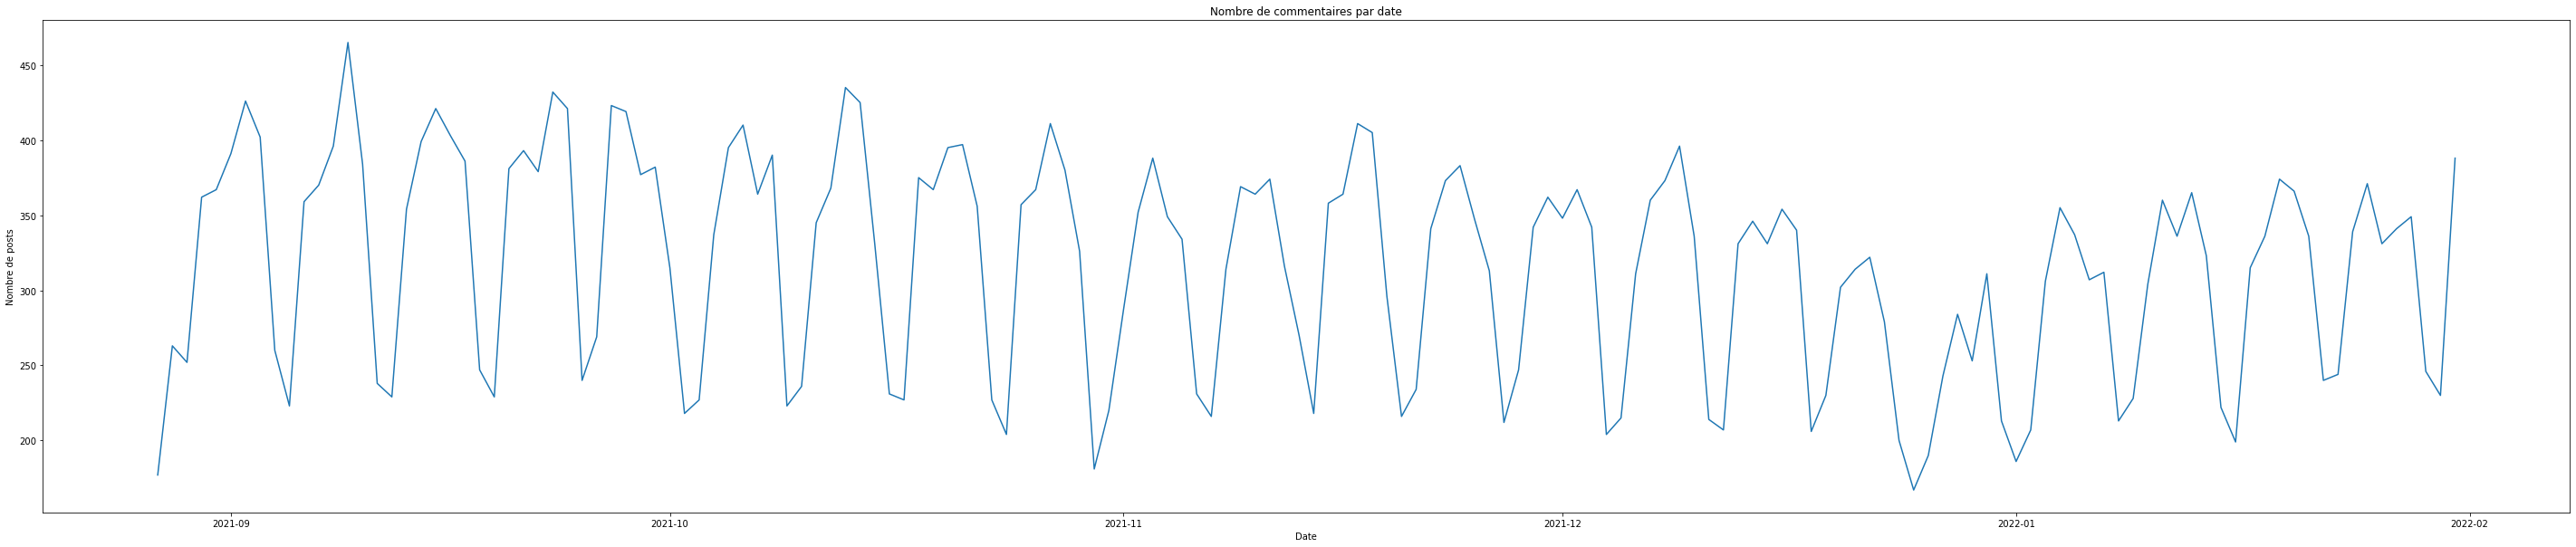

In [5]:
%pylab 
%matplotlib inline
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50,10))
CreationDateByDay = df['CreationDate'].dt.date.value_counts()

sns.lineplot(data=CreationDateByDay, x=CreationDateByDay.index, y=CreationDateByDay.values, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Nombre de posts")
ax.set_title("Nombre de commentaires par date")

plt.show()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


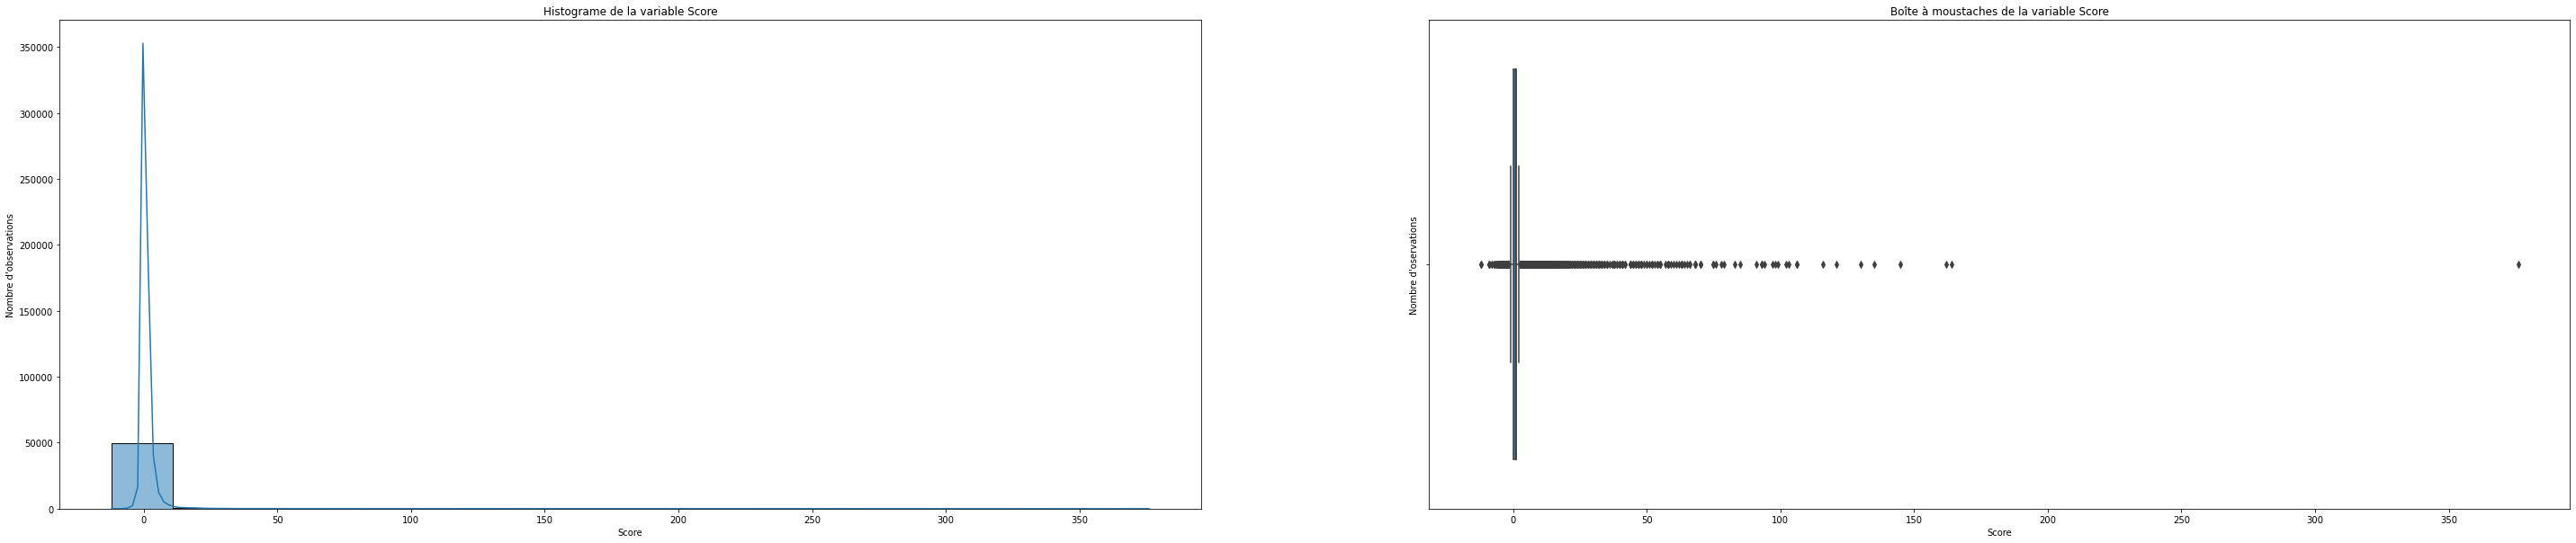


--------------------------------------------------

Indicateurs statistiques de distribution de la variable Score:


count    50000.000000
mean         1.183440
std          4.209649
min        -12.000000
25%          0.000000
50%          1.000000
75%          1.000000
max        376.000000
Name: Score, dtype: float64

In [6]:
%pylab 
%matplotlib inline
import seaborn as sns


def plot_continuous_distribution(data, col, bins='sturges'):
    """
    Plot distribution plot, box plot and statistical distribution figures
    
    Args: 
        data(DataFrame): Name of the dataframe 
        
        col(String): Name of the column to plot
        
    Returns:
        Variable distribution plots and figures
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(50,10))
    
    sns.histplot(data=df, x=col, bins='sturges', kde=True, ax=ax[0])
    ax[0].set_xlabel(f"{col}")
    ax[0].set_ylabel("Nombre d'observations")
    ax[0].set_title(f"Histograme de la variable {col}")
    
    sns.boxplot(data=df, x=col)
    ax[1].set_xlabel(f"{col}")
    ax[1].set_ylabel("Nombre d'oservations")
    ax[1].set_title(f"Boîte à moustaches de la variable {col}")
    plt.show()
    
    print("\n" + "-" * 50 + "\n")
    print(f"Indicateurs statistiques de distribution de la variable {col}:")
    display(data[col].describe())
        
    
plot_continuous_distribution(data=df, col='Score')

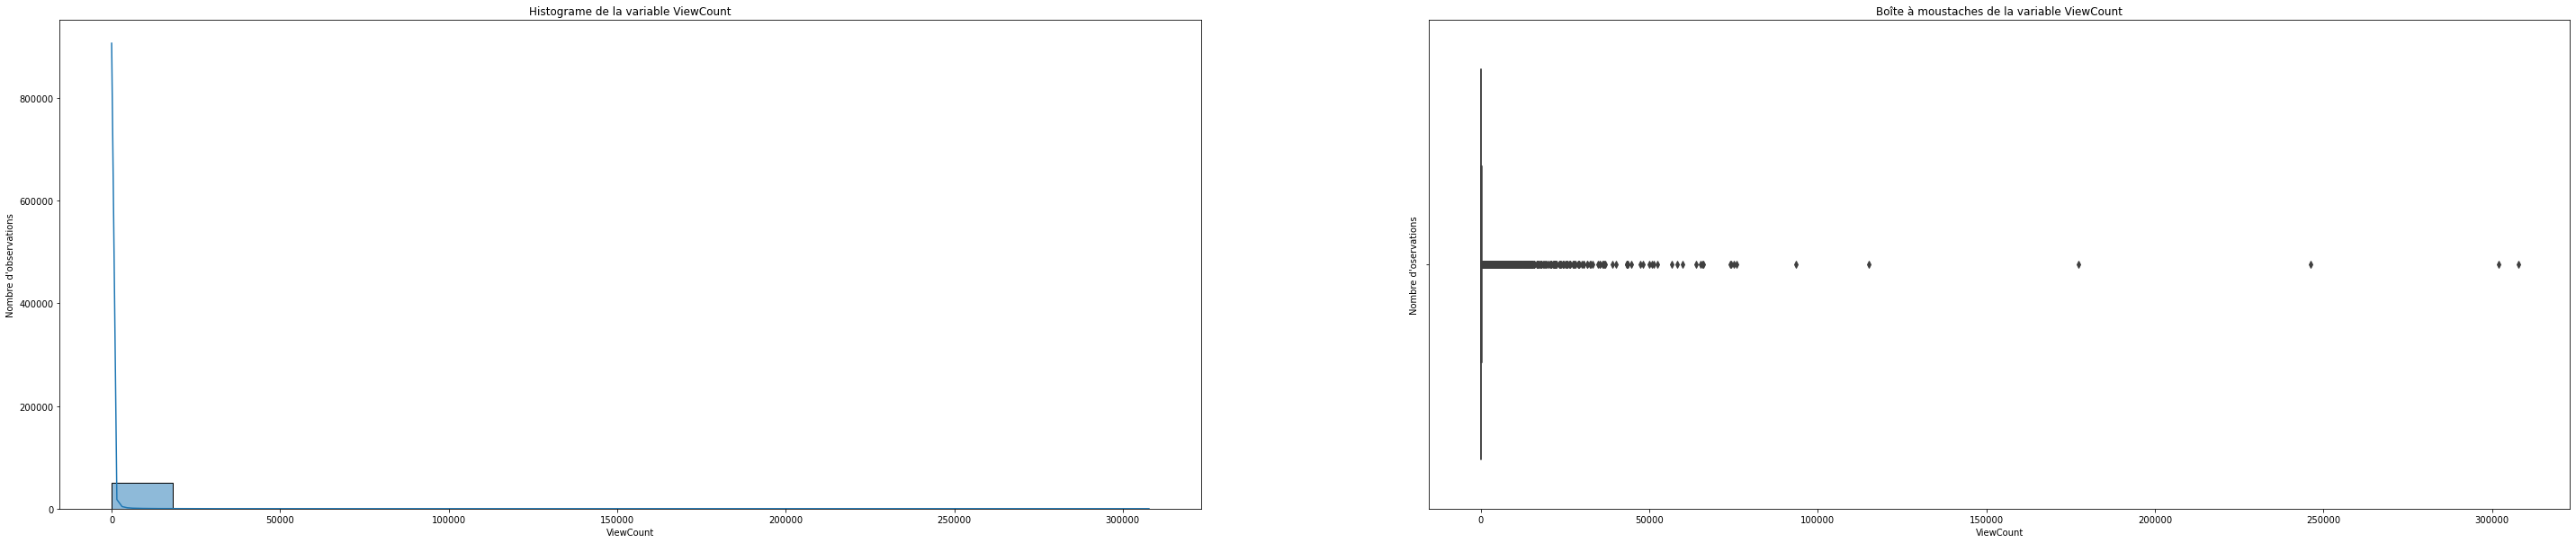


--------------------------------------------------

Indicateurs statistiques de distribution de la variable ViewCount:


count     50000.000000
mean        329.645020
std        3026.319934
min           5.000000
25%          46.000000
50%          74.000000
75%         152.000000
max      307788.000000
Name: ViewCount, dtype: float64

In [7]:
plot_continuous_distribution(data=df, col='ViewCount')

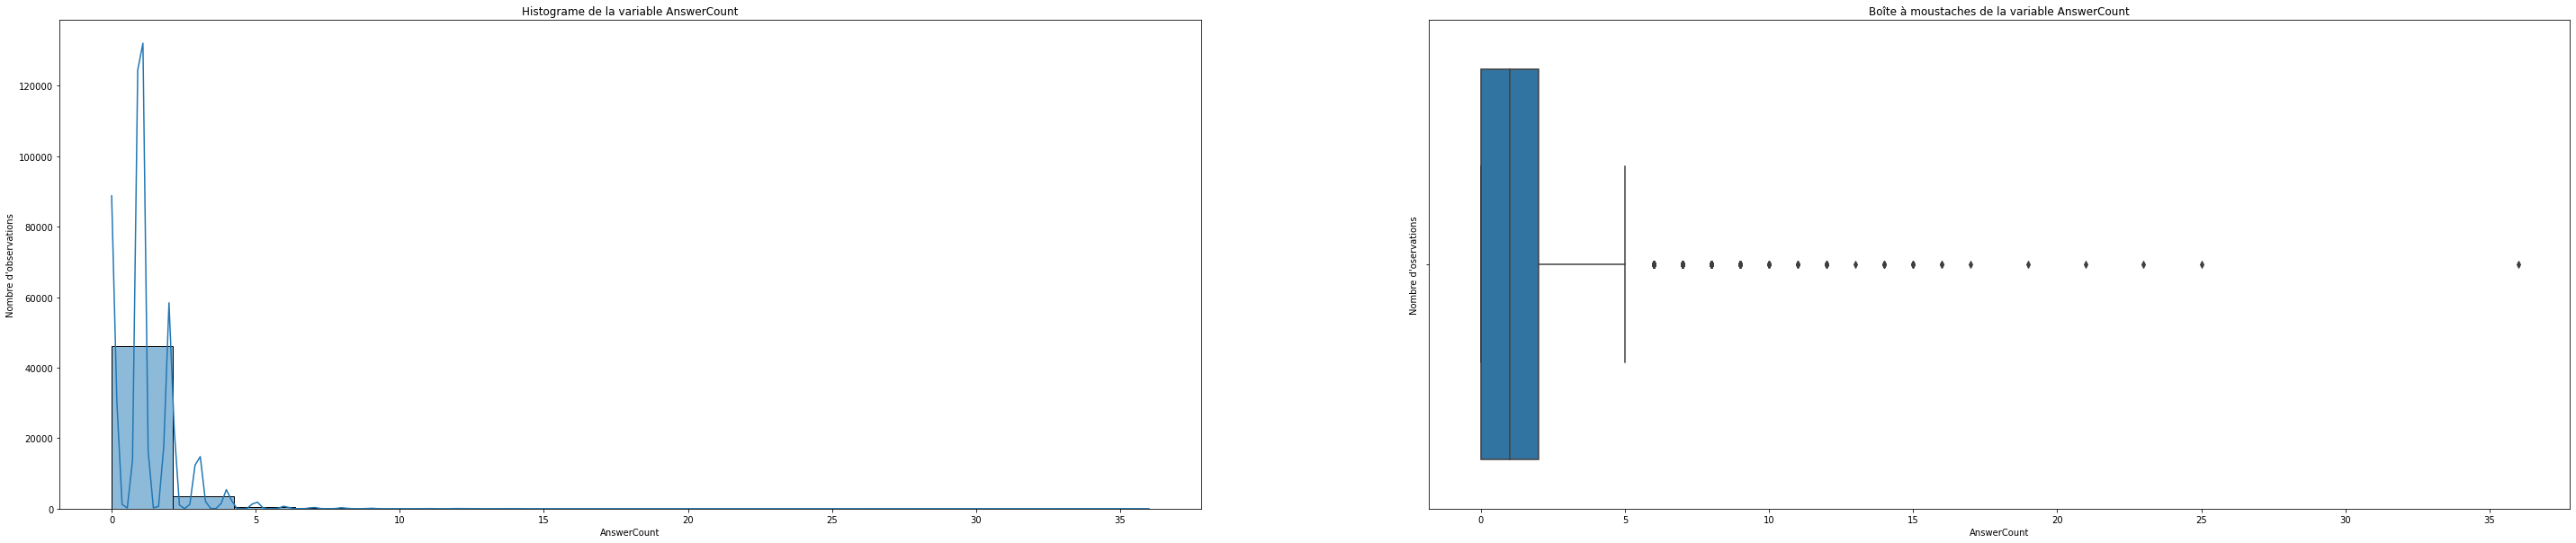


--------------------------------------------------

Indicateurs statistiques de distribution de la variable AnswerCount:


count    50000.000000
mean         1.122220
std          1.075075
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         36.000000
Name: AnswerCount, dtype: float64

In [8]:
plot_continuous_distribution(data=df, col='AnswerCount')


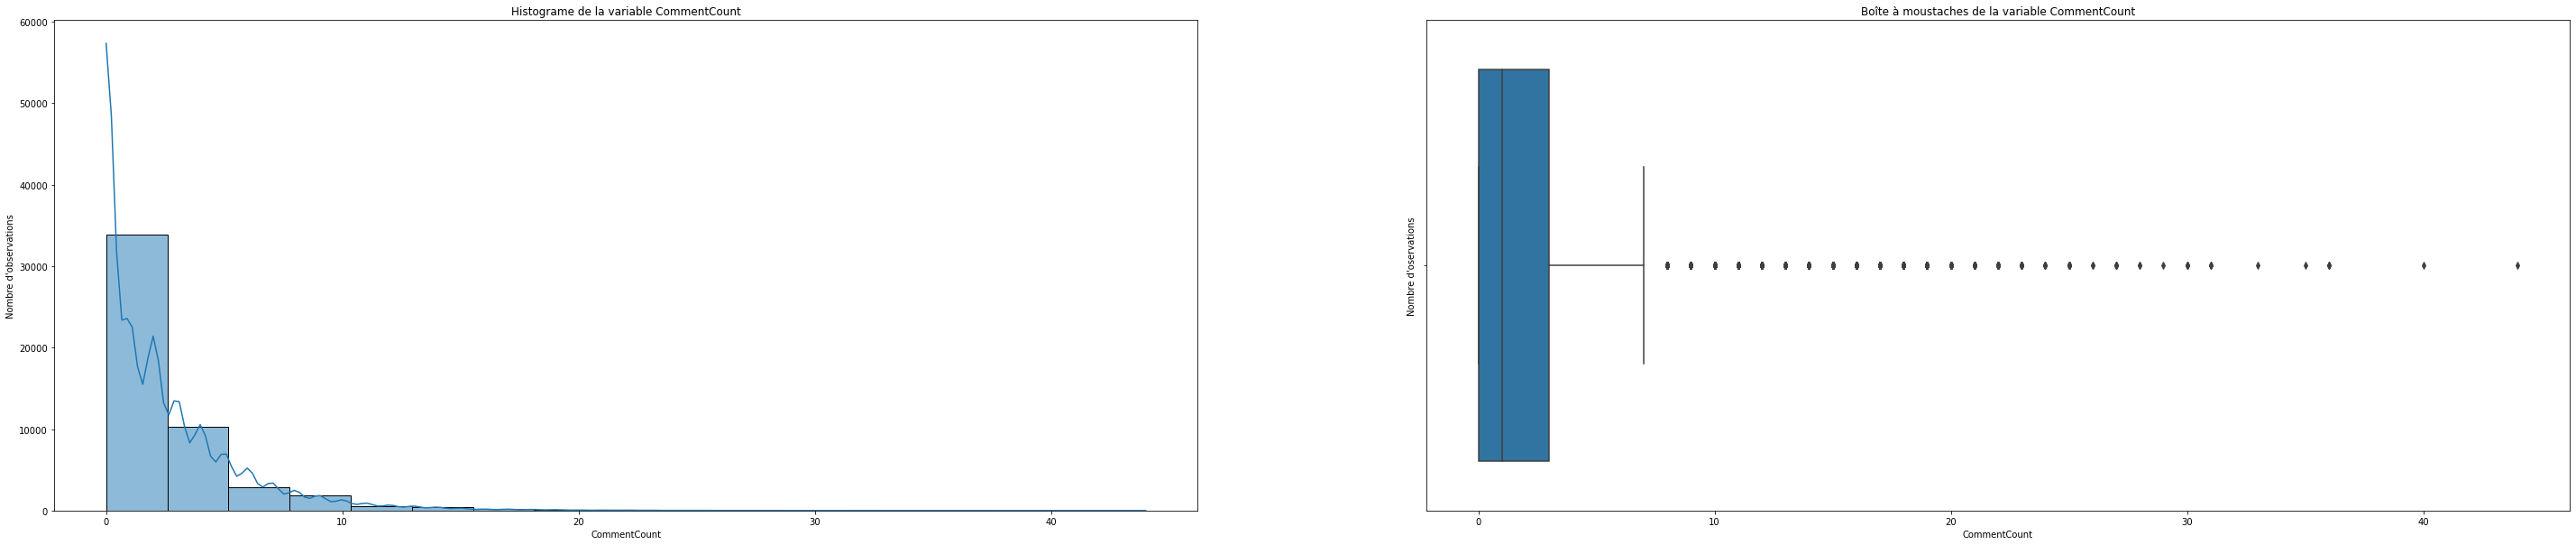


--------------------------------------------------

Indicateurs statistiques de distribution de la variable CommentCount:


count    50000.000000
mean         2.242100
std          3.035838
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         44.000000
Name: CommentCount, dtype: float64

In [9]:
plot_continuous_distribution(data=df, col='CommentCount')

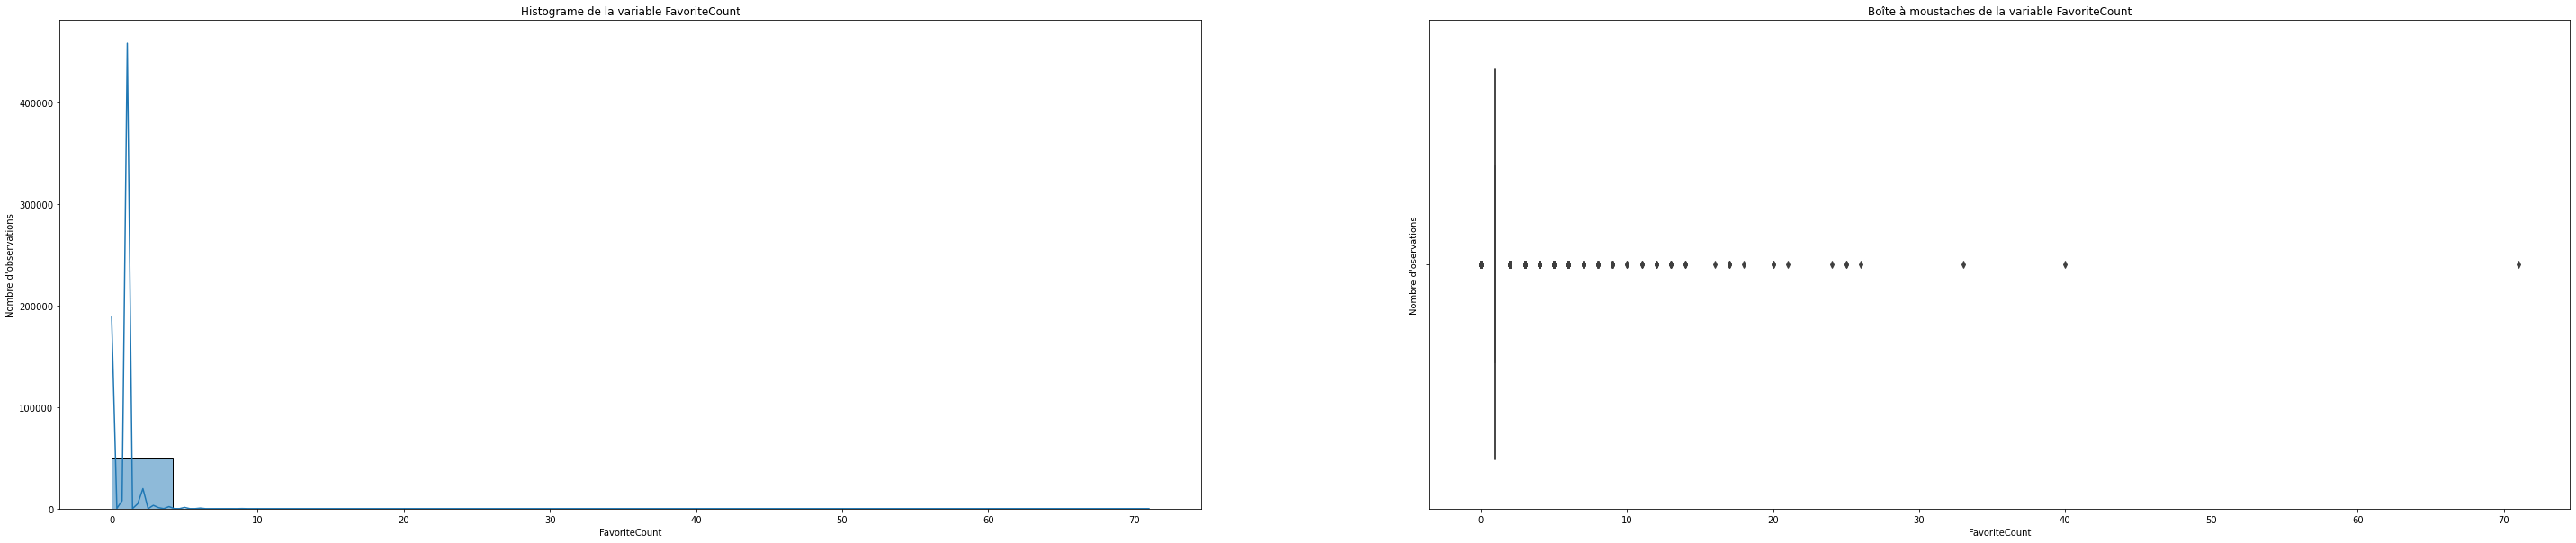


--------------------------------------------------

Indicateurs statistiques de distribution de la variable FavoriteCount:


count    50000.000000
mean         0.904420
std          0.847218
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         71.000000
Name: FavoriteCount, dtype: float64

In [10]:
plot_continuous_distribution(data=df, col='FavoriteCount')

In [11]:
fav_count_filter = df[df["FavoriteCount"]>1].copy()
print(f"Nombre d'observations ayant une valeur supérieure à 1 pour la variable FavoriteCount: {fav_count_filter.shape[0]}")
print(f"Proportion des observations ayant une valeur supérieure à 1 pour la variable FavoriteCount: {round(fav_count_filter.shape[0]/df.shape[0]*100,2)}%")


Nombre d'observations ayant une valeur supérieure à 1 pour la variable FavoriteCount: 4207
Proportion des observations ayant une valeur supérieure à 1 pour la variable FavoriteCount: 8.41%


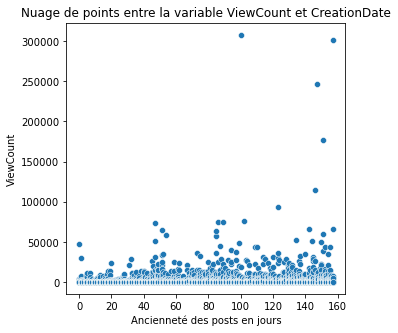

In [17]:
last_post = df["CreationDate"].max()
df["CreationDateTimeDelta"] = last_post - df["CreationDate"]
df["CreationDateTimeDelta"] = df["CreationDateTimeDelta"].dt.days

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
sns.scatterplot(data=df, x="CreationDateTimeDelta", y="ViewCount", ax=ax)
ax.set_xlabel("Ancienneté des posts en jours")
ax.set_label("Nombre de vues")
ax.set_title("Nuage de points entre la variable ViewCount et CreationDate")
plt.show()

In [13]:
def corr_test(var1, var2, method='pearson'):
    """
    Statistical correlation test between two variables.
    
    Args:
        var1(dataframe Series): First Series to check correlation
        
        var2(dataframe Series): Second Series to check correlation
        
        method: Used method to compute correlation metric between 'pearson' and 'spearman'
        
    Returns:
        stat(float): Computed correlation metric
        
        p(float): Computed p value
    
    """
    import scipy.stats as st
    print("-"*50)
    if method == 'pearson':
        print(f"Test statistique de corrélation linéaire de Pearson entre {var1.name} et {var2.name}\n")
        stat, p = st.pearsonr(var1,var2)
        print(f"""Coeficient de corrélation linéaire de Pearson: {stat}\n p valeur: {p}\n""")
        if p < 0.05:
            print("L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%\n" )
        if p > 0.05:
            print("L'hypothèse H0 d'indépendance ne peut être rejetée avec un risque de 5\n")
    if method == 'spearman':
        print(f"Test statistique de corrélation de rang de Spearman entre {var1.name} et {var2.name}\n")
        stat, p = st.spearmanr(var1,var2)
        print(f"""Coeficient de corrélation de rang de Spearman: {stat}\n p valeur: {p}\n""")
        if p < 0.05:
            print("L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%\n" )
        if p > 0.05:
            print("L'hypothèse H0 d'indépendance ne peut être rejetée avec un risque de 5\n")  
            
    print("-"*50)


    return stat, p

corr_test(df["CreationDateTimeDelta"], df["ViewCount"],'pearson')
corr_test(df["CreationDateTimeDelta"], df["ViewCount"],'spearman')

--------------------------------------------------
Test statistique de corrélation linéaire de Pearson entre CreationDateTimeDelta et ViewCount

Coeficient de corrélation linéaire de Pearson: 0.04010561371755175
 p valeur: 2.93107420231872e-19

L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%

--------------------------------------------------
--------------------------------------------------
Test statistique de corrélation de rang de Spearman entre CreationDateTimeDelta et ViewCount

Coeficient de corrélation de rang de Spearman: 0.19394881235579342
 p valeur: 0.0

L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%

--------------------------------------------------


(0.19394881235579342, 0.0)

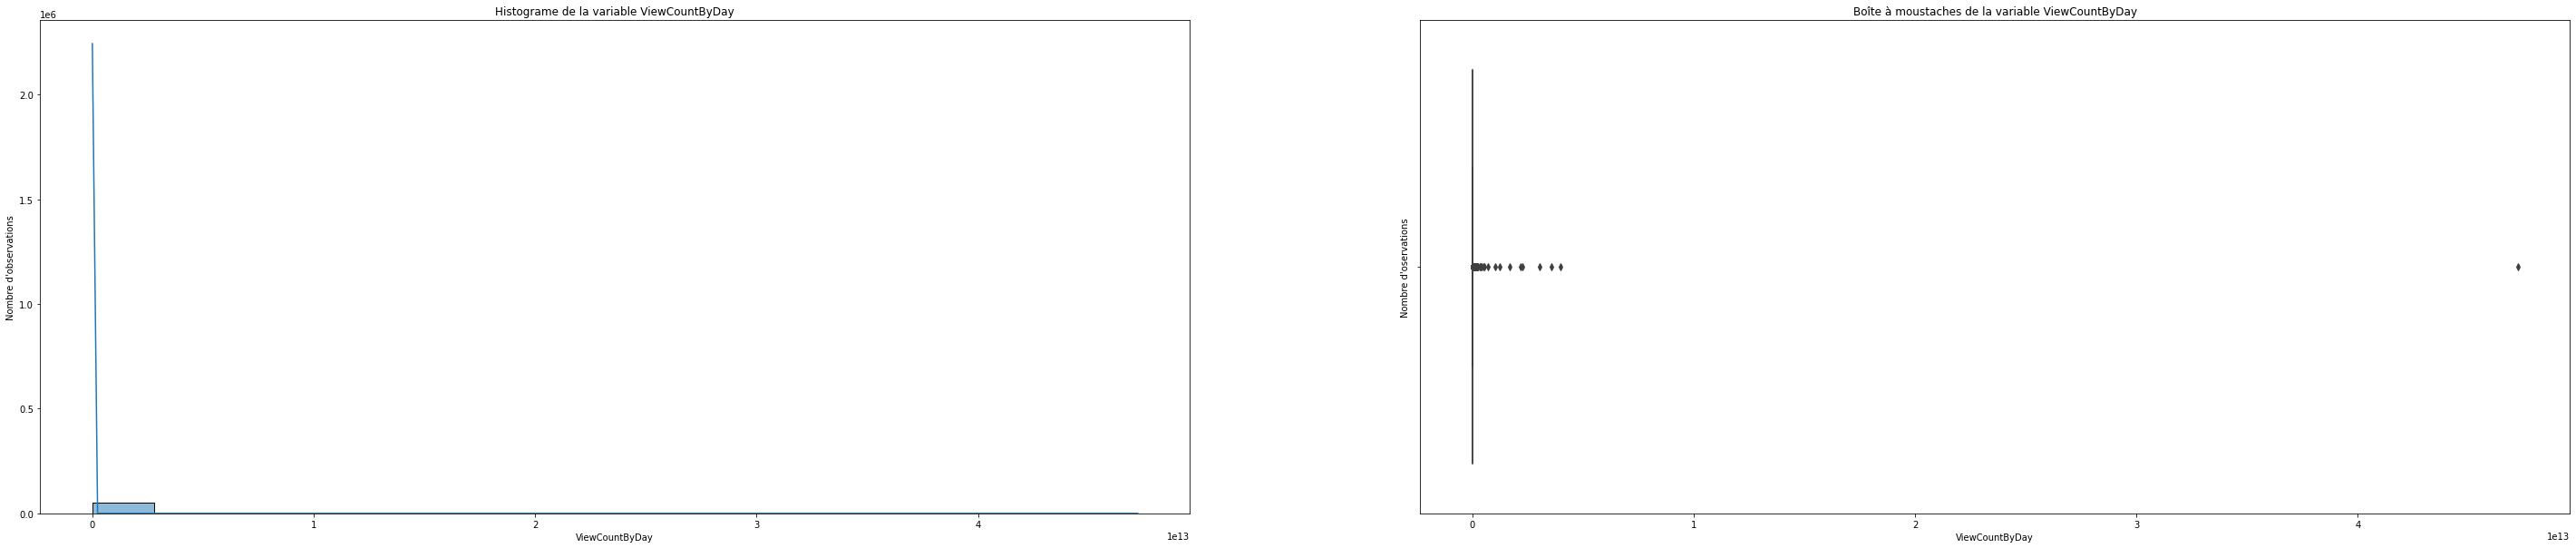


--------------------------------------------------

Indicateurs statistiques de distribution de la variable ViewCountByDay:


count    5.000000e+04
mean     1.799000e+09
std      2.137973e+11
min      3.973510e-02
25%      6.021231e-01
50%      1.250000e+00
75%      3.271886e+00
max      4.721000e+13
Name: ViewCountByDay, dtype: float64

In [14]:
df['ViewCountByDay'] =  df['ViewCount'] / (df['CreationDateTimeDelta']+0.000000001)
plot_continuous_distribution(data=df, col='ViewCountByDay')

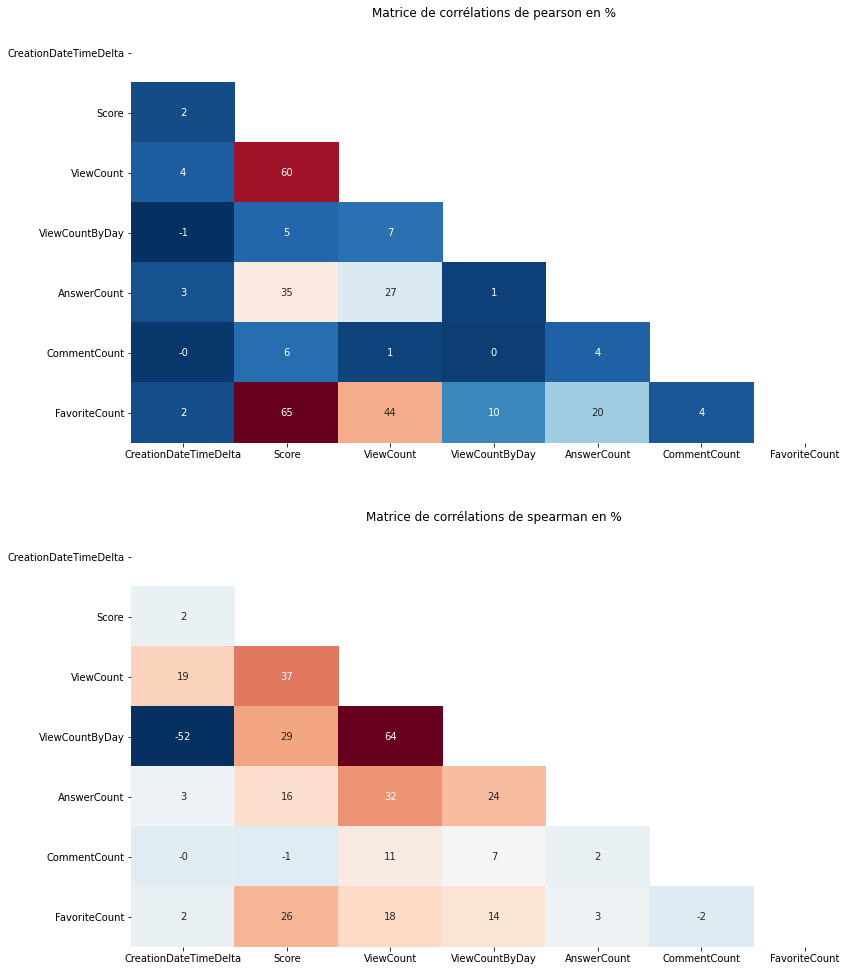

In [24]:
def correlations(df, methods):
    """
    Plot correlation matrix for quantitatives values.
    
    Args:
        data(dataframe): A dataframe
        
        method(string): CHosen method to compute correlation. Might be "pearson", "spearman" or "kendall"
        
    Returns:
        Correlation matrix
    """
    
    correlations = []
    cleanning_masks = []
    for method in methods: 
        correlation = df.select_dtypes(include=['int64','float64']).corr(method=method) * 100
        cleanning_mask = np.zeros_like(correlation)
        upper_triangle = np.triu_indices_from(correlation)
        cleanning_mask[upper_triangle] = 1
        correlations.append(correlation)
        cleanning_masks.append(cleanning_mask)

        
    fig, axes = plt.subplots(nrows=len(methods), figsize=(13,17))
    fig.subplots_adjust(wspace=0.2)

    for i in range(len(axes)):
        sns.heatmap(correlations[i], ax=axes[i], cmap="RdBu_r", mask = cleanning_masks[i], 
                   annot = True, fmt=".0f", cbar=False)

        axes[i].set_title(f"Matrice de corrélations de {methods[i]} en %")
correlations(df[["CreationDate","CreationDateTimeDelta","Score","ViewCount", "ViewCountByDay","AnswerCount","CommentCount","FavoriteCount"]], methods=["pearson", "spearman"])


In [16]:
filtered_data = df[(df['Score'] > 0) &
                           (df['AnswerCount']>0) &
                           (df['CommentCount']>0) &
                           (df['FavoriteCount']>0) &
                           (df['ViewCountByDay']>5)]
filtered_data.sort_values(['Score', 'ViewCount'], ascending=[False, False], inplace=True)
filtered_data_prop = round((filtered_data.shape[0] / df.shape[0] * 100),2)
display(filtered_data)
print(f"Porportion de données restantes: {filtered_data_prop}%")

filtered_data.to_csv(r'C:\Users\sesa638933\Desktop\OC\P5\filtered_data.csv')

<ipython-input-16-55335dbbedb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(['Score', 'ViewCount'], ascending=[False, False], inplace=True)


,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,CreationDateTimeDelta,ViewCountByDay
30290,69692842,2021-10-23 23:39:57,376,307788,23,7,71,"Error message ""error:0308010C:digital envelope...",<p>I created the default IntelliJ IDEA React p...,<node.js><reactjs><webpack><webstorm>,100,3.077880e+03
47856,69034879,2021-09-02 17:36:44,164,177269,8,8,18,"How can I resolve the error ""The minCompileSdk...",<p>The error message:</p>\n<blockquote>\n<p>Th...,<java><android><kotlin><gradle>,151,1.173967e+03
13875,70358643,2021-12-15 04:58:02,162,73924,6,4,33,"""You are running create-react-app 4.0.3 which ...",<p>I got an error while creating a React appli...,<javascript><reactjs><npm-install><yarnpkg><npx>,47,1.572851e+03
35201,69503317,2021-10-09 02:35:26,145,30519,1,6,40,Bubble sort slower with -O3 than -O2 with GCC,"<p>I made a <a href=""https://en.wikipedia.org/...",<c><gcc><x86-64><cpu-architecture><compiler-op...,114,2.677105e+02
38008,69394632,2021-09-30 15:07:50,135,93368,12,1,17,Webpack build failing with ERR_OSSL_EVP_UNSUPP...,<p>I'm having an issue with a Webpack build pr...,<webpack>,123,7.590894e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
81,70931059,2022-01-31 18:31:57,1,31,2,2,1,How to use limit and order_by together in Djan...,<p>I want to use limit on following as [1:10]<...,<django><django-rest-framework><django-queryse...,0,3.100000e+10
1667,70866999,2022-01-26 16:36:32,1,31,1,3,1,Execute and be able to edit each line in a fun...,<p>suppose I have this function</p>\n<pre><cod...,<r>,5,6.200000e+00
61,70932236,2022-01-31 20:10:42,1,30,1,5,1,Typescript type guards for string union types ...,<p>I receive a Typescript error that <code>str...,<typescript>,0,3.000000e+10
978,70897805,2022-01-28 17:28:28,1,30,1,1,1,"Separate dependencies between test, prod, and ...",<p>Currently I am running into long installati...,<docker><npm><next.js><cypress><package.json>,3,1.000000e+01


Porportion de données restantes: 5.57%
